In [2]:
 import tensorflow as tf
 import numpy as np
 import matplotlib.pyplot as plt
 import tensorflow_datasets as tfds
 from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
 from tensorflow.keras.losses import BinaryCrossentropy
 from tensorflow.keras.optimizers import Adam

In [4]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

In [5]:
dataset


[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [6]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

In [7]:
for data in dataset[0].take(5):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

**Splitting the dataset into train , validation and test datasets\**

In [8]:
# split_dataset function split the dataset into train, validation and test sets
def split_dataset(dataset, train_ratio, val_ratio, test_ratio):
  dataset_size = len(dataset)

  train_dataset = dataset.take(int(train_ratio * dataset_size))

  val_test_dataset = dataset.skip(int(train_ratio * dataset_size))
  val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))

  test_dataset = val_test_dataset.skip(int(test_ratio * dataset_size))
  return train_dataset, val_dataset, test_dataset




In [29]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset, val_dataset, test_dataset = split_dataset(dataset[0], train_ratio, val_ratio, test_ratio )
print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()) )

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

**Data Visualization :**
Visualizing some images along with their labels


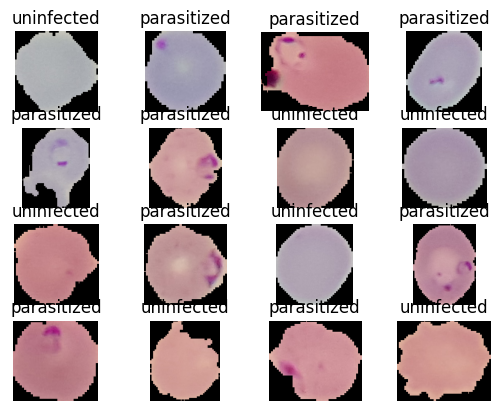

In [8]:
# Take first 16 images from the train dataset
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

**Data Preprocessing**


1. The images need to be resized to a single size.

2. The pixel data also needs to be normalized.


    Normalization = (X - Xmin)/ (Xmax - Xmin)

    In image Xmin = 0, Xmax= 255

In [10]:
# Function to resize and rescale the images
im_size = 224
def resizing_rescale_images(image, label):
  return tf.image.resize(image, (im_size, im_size))/255.0, label

In [30]:
train_dataset = train_dataset.map(resizing_rescale_images)
val_dataset = val_dataset.map(resizing_rescale_images)
test_dataset = test_dataset.map(resizing_rescale_images)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
for image, label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [12]:
#using tf.data API to prefetch data for faster loading of data
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration= True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [13]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration= True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

**CREATING THE MODEL USING KERAS SEQUENTIAL API**

  As we are dealing with images as input, convolution neural network will be used for the classification task.The first few layers would be the convolution layers which would have certain filters that extracts feature information from the input images and sends it through an activation function to create the feature maps.These are then sent through batch normalization layer that promises faster training and easier learning alowing higher learning rates. These feature maps are then passed through a pooling layer. After certain convolution and pooling layers, their output is flattened and passed through a deep neural network to classify the images into their corresponding category. The output of the overall model would be a probability distribution providing the probability of each category and the class with highest probability is selected as the result of the model.

In [14]:
model= tf.keras.Sequential([
    InputLayer(input_shape = (im_size,im_size,3)),

    Conv2D(filters=6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),

    Conv2D(filters=16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),



    Flatten(),

    Dense(100,activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),


])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

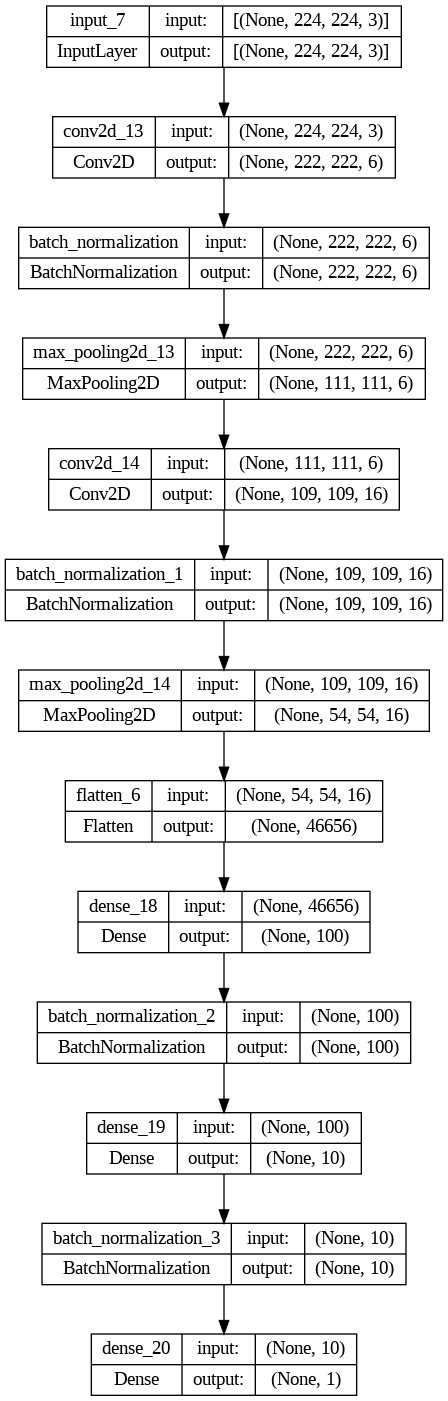

In [92]:

tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True)

**Compiling the model**

    Optimizer: Adam
    learning rate:0.1
    Loss: BinaryCrossentropy
    Evaluation metric: Accuracy

In [15]:
model.compile(
    optimizer= Adam(learning_rate=0.01),
    loss= BinaryCrossentropy(),
    metrics = 'accuracy'
)

**Training the model**

In [16]:
trained_model = model.fit(train_dataset, validation_data=val_dataset, epochs=50, verbose=1)

Epoch 1/50
689/689 [==============================] - 58s 73ms/step - loss: 0.4449 - accuracy: 0.7858 - val_loss: 4.5854 - val_accuracy: 0.5089
Epoch 2/50
689/689 [==============================] - 56s 81ms/step - loss: 0.2293 - accuracy: 0.9179 - val_loss: 0.1919 - val_accuracy: 0.9401
Epoch 3/50
689/689 [==============================] - 54s 79ms/step - loss: 0.2158 - accuracy: 0.9269 - val_loss: 0.2725 - val_accuracy: 0.9085
Epoch 4/50
689/689 [==============================] - 49s 70ms/step - loss: 0.1895 - accuracy: 0.9358 - val_loss: 0.2825 - val_accuracy: 0.8672
Epoch 5/50
689/689 [==============================] - 49s 71ms/step - loss: 0.1771 - accuracy: 0.9408 - val_loss: 0.3434 - val_accuracy: 0.9042
Epoch 6/50
689/689 [==============================] - 49s 71ms/step - loss: 0.1722 - accuracy: 0.9402 - val_loss: 3.3264 - val_accuracy: 0.7641
Epoch 7/50
689/689 [==============================] - 49s 71ms/step - loss: 0.1553 - accuracy: 0.9468 - val_loss: 0.4826 - val_accuracy:

**Visualizing the model loss and performance**

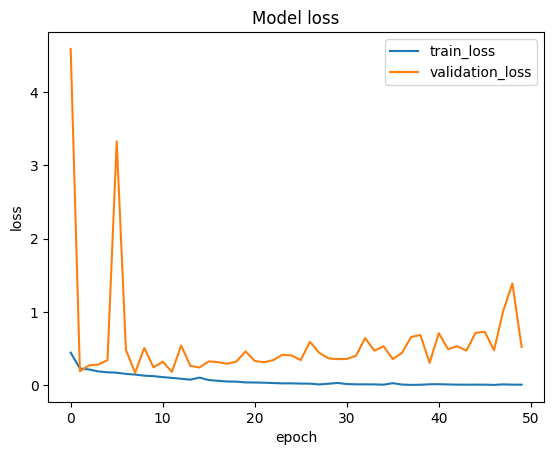

In [17]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','validation_loss'])
plt.show()

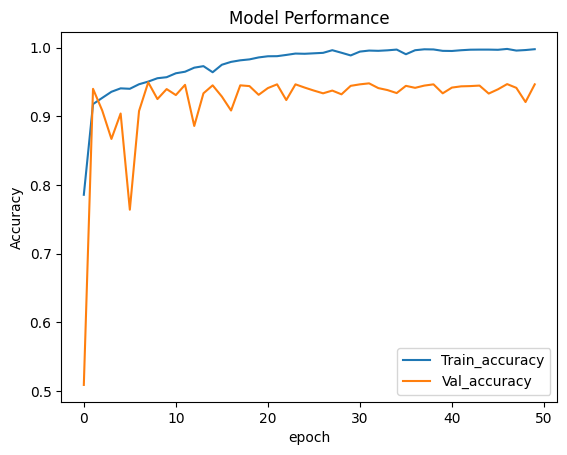

In [19]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('Model Performance')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train_accuracy','Val_accuracy'])
plt.show()

**Evaluating and testing the model**

In [31]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [21]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 23s 4ms/step - loss: 0.4843 - accuracy: 0.9434


[0.4843154847621918, 0.9434167742729187]

In [23]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


0.978218

In [24]:
# Function that sets a condition for whether the predicted probability leads to an infected(I) or not infected(NI)
def infected_or_not(x):
  if(x<0.5):
    return str('I')
  else:
    return str('NI')

1/1 [==============================] - 0s 19ms/step


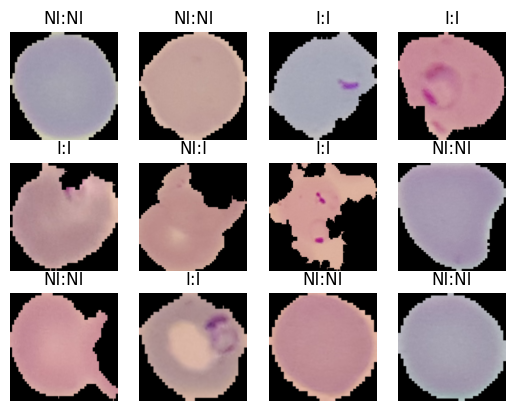

In [35]:
# Visualizing the actual vs predicted class
for i, (image,label) in enumerate(test_dataset.take(12)):
  ax= plt.subplot(3,4, i+1)
  plt.imshow(image[0])
  plt.title(str(infected_or_not(label.numpy()[0])) + ":" + str(infected_or_not(model.predict(image)[0][0])))
  plt.axis('off')